In this notebook we will train a Variational Auto-Encoder VAE, which will (hopefully) translate all UI images into some n-dimensional space, in which we can then do the optimising.

We will use [https://github.com/AntixK/PyTorch-VAE](https://github.com/AntixK/PyTorch-VAE/tree/master) as a basis.

In [1]:
!nvidia-smi

Sun Jun 16 09:58:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:81:00.0 Off |                    0 |
| N/A   51C    P0             141W / 400W |  32820MiB / 40960MiB |     12%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
from os import listdir
from os.path import isfile, join
import json
from utils import calculate_initial_theta, stack_alpha_aware, transform_to_t
from math import prod
from loguru import logger
import matplotlib.pyplot as plt
import torch
from PIL import Image
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')

In [3]:
import torchvision.transforms as T
from torchvision import datasets, transforms
transform_t_to_pil = T.ToPILImage()
transform_to_t = transforms.Compose([transforms.ToTensor()])

In [4]:
from torch import nn
from torch.utils.data import Dataset
from abc import abstractmethod

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError
    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

Proposed in_channels:

Almost all UIs will have 3 Buttons and 3 `FIXME` objects. So we will input an ordered list into it of the respective normalised (between 0 and 1) positions.

In [5]:
def get_all_clickable_resources(item, should_be_clickable):
    if item is None:
        return []
    all_boxes = []
    if "bounds" in item.keys() and "resource-id" in item.keys() and "clickable" in item.keys() and item["clickable"]==should_be_clickable and item["visible-to-user"]:
        all_boxes.append((item["bounds"],item["resource-id"]))
    if "children" in item.keys():
        for child in item["children"]:
            for box in get_all_clickable_resources(child,should_be_clickable):
                all_boxes.append(box)
    return all_boxes

def get_all_bounding_boxes(item, should_be_clickable):
    bboxes = get_all_clickable_resources(item,should_be_clickable)
    reduced_bboxes = []
    already_seen_ids = []
    for box,r_id in bboxes:
        if r_id not in already_seen_ids:
            reduced_bboxes.append(box)
            already_seen_ids.append(r_id)
    return reduced_bboxes


In [6]:
NORMAL_UI_DIMENSIONS = (1440, 2560)

class CustomRicoDataset(Dataset):
    def __init__(self, combined_path="./combined", also_return_filename=False):
        self.image_files = [
            f
            for f in listdir(combined_path)
            if isfile(join(combined_path, f)) and ("jpg" in f or "jpeg" in f)
        ]
        self.combined_path = combined_path
        self.also_return_filename = also_return_filename

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = join(self.combined_path,self.image_files[idx])
        json_path = join(self.combined_path,self.image_files[idx].split(".")[0]+".json")
        with open(json_path, "r") as f:
            image_json = json.load(f)
        
        clickable_segments = get_all_bounding_boxes(image_json["activity"]["root"], True)
        reduced_clickable_segments = [
            box
            for box in clickable_segments
            if (prod([box[2]-box[0],box[3]-box[1]]) > 1) and prod([box[2]-box[0],box[3]-box[1]]) < 0.8 * 1440 * 2560
        ]
        normalised_clickable_boxes = []
        for box in reduced_clickable_segments:
            w,h = box[2]-box[0], box[3]-box[1]
            normalised_clickable_boxes.append([w/NORMAL_UI_DIMENSIONS[0],h/NORMAL_UI_DIMENSIONS[1]])
        not_clickable_segments = get_all_bounding_boxes(image_json["activity"]["root"], False)
        not_reduced_clickable_segments = [
            box
            for box in not_clickable_segments
            if (prod([box[2]-box[0],box[3]-box[1]]) > 1) and prod([box[2]-box[0],box[3]-box[1]]) < 0.8 * 1440 * 2560
        ]
        normalised_not_clickable_boxes = []
        for box in not_reduced_clickable_segments:
            w,h = box[2]-box[0], box[3]-box[1]
            normalised_not_clickable_boxes.append([w/NORMAL_UI_DIMENSIONS[0],h/NORMAL_UI_DIMENSIONS[1]])
        

        if len(normalised_clickable_boxes) < 5 or len(normalised_not_clickable_boxes) < 5:
            # logger.warning(f"Ignoring Index {idx} because of too little elements...")
            if idx == (len(self)-1):
                return self[idx-100]
            return self[idx+1]
        # return normalised_clickable_boxes[:5], normalised_not_clickable_boxes[:5]
        if self.also_return_filename:
            return torch.tensor(normalised_clickable_boxes[:5]+normalised_not_clickable_boxes[:5]).unsqueeze(0), img_path
        else:
            return torch.tensor(normalised_clickable_boxes[:5]+normalised_not_clickable_boxes[:5]).unsqueeze(0)


In [7]:
dataset = CustomRicoDataset("../combined")

In [8]:
sample_idx = torch.randint(len(dataset), size=(1,)).item()
j = dataset[sample_idx]

In [9]:
j

tensor([[[0.1167, 0.0656],
         [0.1167, 0.0656],
         [1.0000, 0.3777],
         [0.1750, 0.0984],
         [0.1750, 0.0984],
         [1.0000, 0.0766],
         [1.0000, 0.0684],
         [1.0000, 0.4117],
         [0.2444, 0.0297],
         [0.4750, 0.2672]]])

In [10]:
import torch
# from models import BaseVAE
from torch import nn
from torch.nn import functional as F
# from .types_ import *


class VanillaVAE(BaseVAE):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    #nn.Conv2d(in_channels, out_channels=h_dim,
                    #          kernel_size= 3, stride= 2, padding  = 1),
                    nn.Linear(in_channels, h_dim),
                    # nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*10, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*10, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 10)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    #nn.ConvTranspose2d(hidden_dims[i],
                    #                   hidden_dims[i + 1],
                    #                   kernel_size=3,
                    #                   stride = 2,
                    #                   padding=1,
                    #                   output_padding=1),
                    #nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.Linear(hidden_dims[i], hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            #nn.ConvTranspose2d(hidden_dims[-1],
                            #                   hidden_dims[-1],
                            #                   kernel_size=3,
                            #                   stride=2,
                            #                   padding=1,
                            #                   output_padding=1),
                            #nn.BatchNorm2d(hidden_dims[-1]),
                            nn.Linear(hidden_dims[-1],hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Linear(hidden_dims[-1],2),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 10, 512)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [11]:
vae = VanillaVAE(in_channels=2, latent_dim=32)

In [12]:
#j_tensor = torch.tensor(j[0]+j[1]).unsqueeze(0)
recons, inp, mu, log_var = vae.forward(j)

In [13]:
loss = vae.loss_function(recons,inp,mu,log_var, M_N=1)

In [14]:
loss

{'loss': tensor(0.1709, grad_fn=<AddBackward0>),
 'Reconstruction_Loss': tensor(0.1574),
 'KLD': tensor(-0.0134)}

In [15]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from accelerate import Accelerator

train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [16]:
accelerator = Accelerator()

In [17]:
optimizer = torch.optim.Adam(vae.parameters(),
                               lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=25)

In [18]:
vae, optimizer, train_dataloader, scheduler = accelerator.prepare(vae,optimizer, train_dataloader, scheduler)

In [19]:
vae

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=5120, out_features=32, bias=True)
  (fc_var): Linear(in_features=5120, out_features=32, bias=True)
  (decoder_input): Linear(in_features=32, out_features=5120, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=512, out_features=256, 

In [20]:
force_retrain = False
losses = []
if not isfile("./vae_pretrained") or force_retrain:
    for batch in tqdm(train_dataloader):
        # j_tensor = .to(accelerate)
        # print(batch)
        recons, inp, mu, log_var = vae.forward(batch)
        loss = vae.loss_function(recons,inp,mu,log_var, M_N=64)
        # loss["loss"].backward()
        
        accelerator.backward(loss["loss"])
    
        torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.5)
    
        
        optimizer.step()
        
        # logger.info(f"{loss['loss'].item()}, lr: {scheduler.get_last_lr()[0]}")
        losses.append(loss["loss"].detach().cpu().item())
        scheduler.step(loss["loss"])
    torch.save(vae.state_dict(), "./vae_pretrained")
else:
    vae.load_state_dict(torch.load("./vae_pretrained"))
    vae.eval()

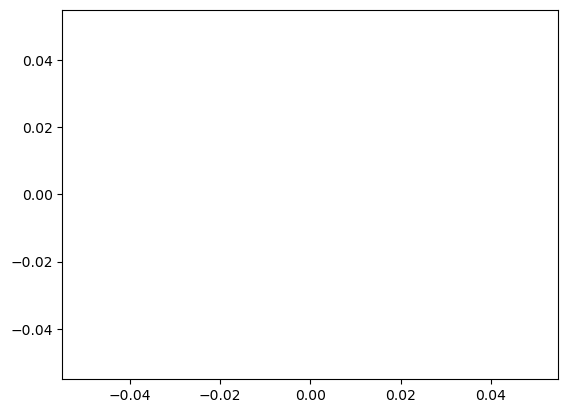

In [21]:
plt.plot(losses)
plt.show()

In [22]:
losses[-1]

IndexError: list index out of range

In [23]:
dataset[0].shape

torch.Size([1, 10, 2])

In [24]:
recons, inp, mu, log_var = vae.forward(dataset[100].to(accelerator.device))
z = vae.reparameterize(mu, log_var)

In [25]:
inp

tensor([[[0.7056, 0.0602],
         [0.1556, 0.0574],
         [0.1556, 0.0574],
         [0.1069, 0.0574],
         [1.0000, 0.0602],
         [0.0778, 0.0437],
         [0.5792, 0.0242],
         [0.1750, 0.0195],
         [0.9514, 0.0297],
         [0.9514, 0.0480]]], device='cuda:0')

In [26]:
recons

tensor([[[0.4177, 0.1143],
         [0.4112, 0.1092],
         [0.4115, 0.1087],
         [0.4118, 0.1097],
         [0.4111, 0.1091],
         [0.9061, 0.2306],
         [0.7429, 0.1911],
         [0.6732, 0.1796],
         [0.6497, 0.1752],
         [0.5954, 0.1656]]], device='cuda:0', grad_fn=<TanhBackward0>)

In [27]:
z

tensor([[ 0.2086,  1.2120, -1.3973,  0.2151, -0.9965,  1.8594, -0.3839,  1.1927,
          0.3697, -0.4448,  1.0871,  0.8981,  1.1182, -0.1804, -0.7244,  1.0172,
         -0.2257, -0.1305,  0.5787, -1.2264, -0.1968,  0.6846, -0.3282, -1.0000,
          0.6524,  0.1356, -0.8049,  1.8933,  1.4232, -0.6847,  1.0808,  0.3302]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [28]:
# We need to modify this function to avoid np conversions and differentiation problems
def calculate_initial_theta(segment, canvas_size, original_position):
    # Theta consists of 6 values, 4 of which we have to calculate.
    x_ratio = canvas_size[0] / segment.size[0]
    y_ratio = canvas_size[1] / segment.size[1]
    # grid_location_x and grid_location_y are basically percentages of height and width and not actual coordinates
    # Because we already warp the segment onto a bigger canvas, this transformation is a bit complicated
    # grid_location_x has to be in the interval [-(x_ratio-1),(x_ratio-1)], i.e. 0 means -(x_ratio - 1) and 1440 means (x_ratio - 1)
    # We can map U ~ [0, 1] to U ~ [a, b] with u -> (a - b)*u + b
    # We first map U ~ [0, max_width] to U ~ [0,1] by dividing by max_width

    eps = 0.00001 # Avoid div by zero
    original_x_position = (original_position[0]) / (canvas_size[0]-segment.size[0]+eps)
    mapped_x_position = (-(x_ratio - 1) - (x_ratio - 1))*original_x_position + (x_ratio-1)

    original_y_position = (original_position[1]) / (canvas_size[1]-segment.size[1]+eps)
    mapped_y_position = (-(y_ratio - 1) - (y_ratio - 1))*original_y_position + (y_ratio-1)

    theta = torch.tensor([
        [0.0,0.0,0.0],
        [0.0,0.0,0.0]
    ]).to(accelerator.device)
    
    theta[0][0] += x_ratio
    theta[1][1] += y_ratio
    theta[0][2] += mapped_x_position
    theta[1][2] += mapped_y_position
    
    #return np.array([
    #    [x_ratio, 0.0    , mapped_x_position],
    #    [0.0    , y_ratio, mapped_y_position]
    #])
    return theta

In [29]:
class MultivariateNormalPDF(nn.Module):
    def __init__(self, mean, covariance, device):
        super(MultivariateNormalPDF, self).__init__()
        self.mean = mean.to(device)
        self.covariance = covariance.to(device)
        self.inv_covariance = torch.inverse(covariance).to(device)
        self.det_covariance = torch.det(covariance).to(device)
        self.dim = mean.size(0)
        self.const = torch.sqrt((2 * torch.pi) ** self.dim * self.det_covariance).to(device)
    
    def forward(self, x):
        diff = x - self.mean
        exp_term = -0.5 * torch.sum(diff @ self.inv_covariance * diff, dim=1)
        return torch.exp(exp_term) / self.const

class MultivariateNormalLoss(nn.Module):
    def __init__(self, mean, covariance, device="cpu"):
        super(MultivariateNormalLoss, self).__init__()
        self.pdf = MultivariateNormalPDF(mean, covariance,device)
        self.pdf = self.pdf.to(device)
    
    def forward(self, x):
        pdf_values = self.pdf(x)
        nll = -torch.log(pdf_values + 1e-8)  # Adding epsilon to prevent log(0)
        return nll.mean()

In [30]:
class GradientDescent(torch.nn.Module):
    def __init__(self, vae, z, segments, aesthetics_predictor, device):
        super().__init__()
        self.vae = vae
        self.z = torch.nn.Parameter(z.to(device))
        self.vae = self.vae.eval().to(device)
        self.segments = segments
        self.device = device
        self.aesthetics_predictor = aesthetics_predictor.to(self.device)
        
        self.canvas_size = (1,3,NORMAL_UI_DIMENSIONS[1],NORMAL_UI_DIMENSIONS[0])
        self.mean = torch.zeros(self.z.shape[1]).to(self.device)
        print(f"Mean shape: {self.mean.shape}")
        self.cov = torch.eye(z.shape[1]).to(self.device)
        print(f"Cov shape: {self.cov.shape}")
        self.mn_loss = MultivariateNormalLoss(self.mean, self.cov, self.device)

    def forward(self):
        decoded = self.vae.decode(self.z)
        print(decoded)
        decoded_denormalised = decoded * torch.tensor([NORMAL_UI_DIMENSIONS[0],NORMAL_UI_DIMENSIONS[1]]).to(self.device)
        segments_on_canvas = []
        
        for n in range(len(self.segments)):
            theta = calculate_initial_theta(self.segments[n],NORMAL_UI_DIMENSIONS,decoded_denormalised[0][n]) 
            theta = theta.unsqueeze(0).to(self.device)

            if self.device == "cpu":
                grid = F.affine_grid(theta, self.canvas_size).type(torch.FloatTensor)
            else:
                grid = F.affine_grid(theta, self.canvas_size).type(torch.FloatTensor).to(self.device)
            x = F.grid_sample(transform_to_t(self.segments[n]).unsqueeze(0).to(self.device), grid)
            segments_on_canvas.append(x)
        print(segments_on_canvas[-1].device)
        generated_image = stack_alpha_aware(segments_on_canvas)
        generated_image = generated_image[:3]

        print(f"Max val: {generated_image.max()}")
        print(f"generated_image.unsqueeze(0) device: {generated_image.unsqueeze(0).device}")
        score = self.aesthetics_predictor(generated_image.unsqueeze(0))

        mn_loss = self.mn_loss(self.z)
            
        return score, generated_image, mn_loss

In [31]:
test_dataset = CustomRicoDataset("../combined",True)

In [32]:
test_dataset.image_files[0]

'70987.jpg'

In [33]:
dataset_index = 10291

In [34]:
test_dataset[dataset_index]

(tensor([[[0.1167, 0.0656],
          [0.1750, 0.0984],
          [0.3333, 0.0766],
          [0.3333, 0.0766],
          [0.3333, 0.0766],
          [1.0000, 0.3855],
          [1.0000, 0.3090],
          [1.0000, 0.0766],
          [1.0000, 0.0297],
          [0.2146, 0.0297]]]),
 '../combined/51422.jpg')

In [35]:
# Quite lengthy and manual process to retrieve the segments of the first 5 clickable and first 5 non-clickable
img_path = test_dataset[dataset_index][1]
json_path = test_dataset[dataset_index][1].replace(".jpg",".json")

image = Image.open(img_path)
image = image.convert('RGBA')
image = image.resize((1440, 2560), Image.Resampling.LANCZOS)

with open(json_path, "r") as f:
    image_json = json.load(f)

clickable_segments = get_all_bounding_boxes(image_json["activity"]["root"], True)
reduced_clickable_segments = [
    box
    for box in clickable_segments
    if (prod([box[2]-box[0],box[3]-box[1]]) > 1) and prod([box[2]-box[0],box[3]-box[1]]) < 0.8 * 1440 * 2560
]
reduced_clickable_segmented_cropped = []
for box in reduced_clickable_segments:
    anchor_point = (box[0],box[1])
    width = box[2]-box[0]
    height = box[3]-box[1]
    try:
        cropped_image = image.crop((box[0],box[1],box[2],box[3]))
    except ValueError:
        continue
    # Only include segments that are less than 90% the size of the original image
    if (prod([box[2]-box[0],box[3]-box[1]]) > 1) and prod([box[2]-box[0],box[3]-box[1]]) < 0.8 * 1440 * 2560:
        reduced_clickable_segmented_cropped.append(cropped_image)

not_clickable_segments = get_all_bounding_boxes(image_json["activity"]["root"], False)
not_reduced_clickable_segments = [
    box
    for box in not_clickable_segments
    if (prod([box[2]-box[0],box[3]-box[1]]) > 1) and prod([box[2]-box[0],box[3]-box[1]]) < 0.8 * 1440 * 2560
]
reduced_not_clickable_segmented_cropped = []
for box in not_reduced_clickable_segments:
    anchor_point = (box[0],box[1])
    width = box[2]-box[0]
    height = box[3]-box[1]
    try:
        cropped_image = image.crop((box[0],box[1],box[2],box[3]))
    except ValueError:
        continue
    # Only include segments that are less than 90% the size of the original image
    if (prod([box[2]-box[0],box[3]-box[1]]) > 1) and prod([box[2]-box[0],box[3]-box[1]]) < 0.8 * 1440 * 2560:
        reduced_not_clickable_segmented_cropped.append(cropped_image)

if len(reduced_clickable_segmented_cropped) < 5 or len(reduced_not_clickable_segmented_cropped) < 5:
    raise ValueError
# return normalised_clickable_boxes[:5], normalised_not_clickable_boxes[:5]
segments = reduced_clickable_segmented_cropped[:5]+reduced_not_clickable_segmented_cropped[:5]

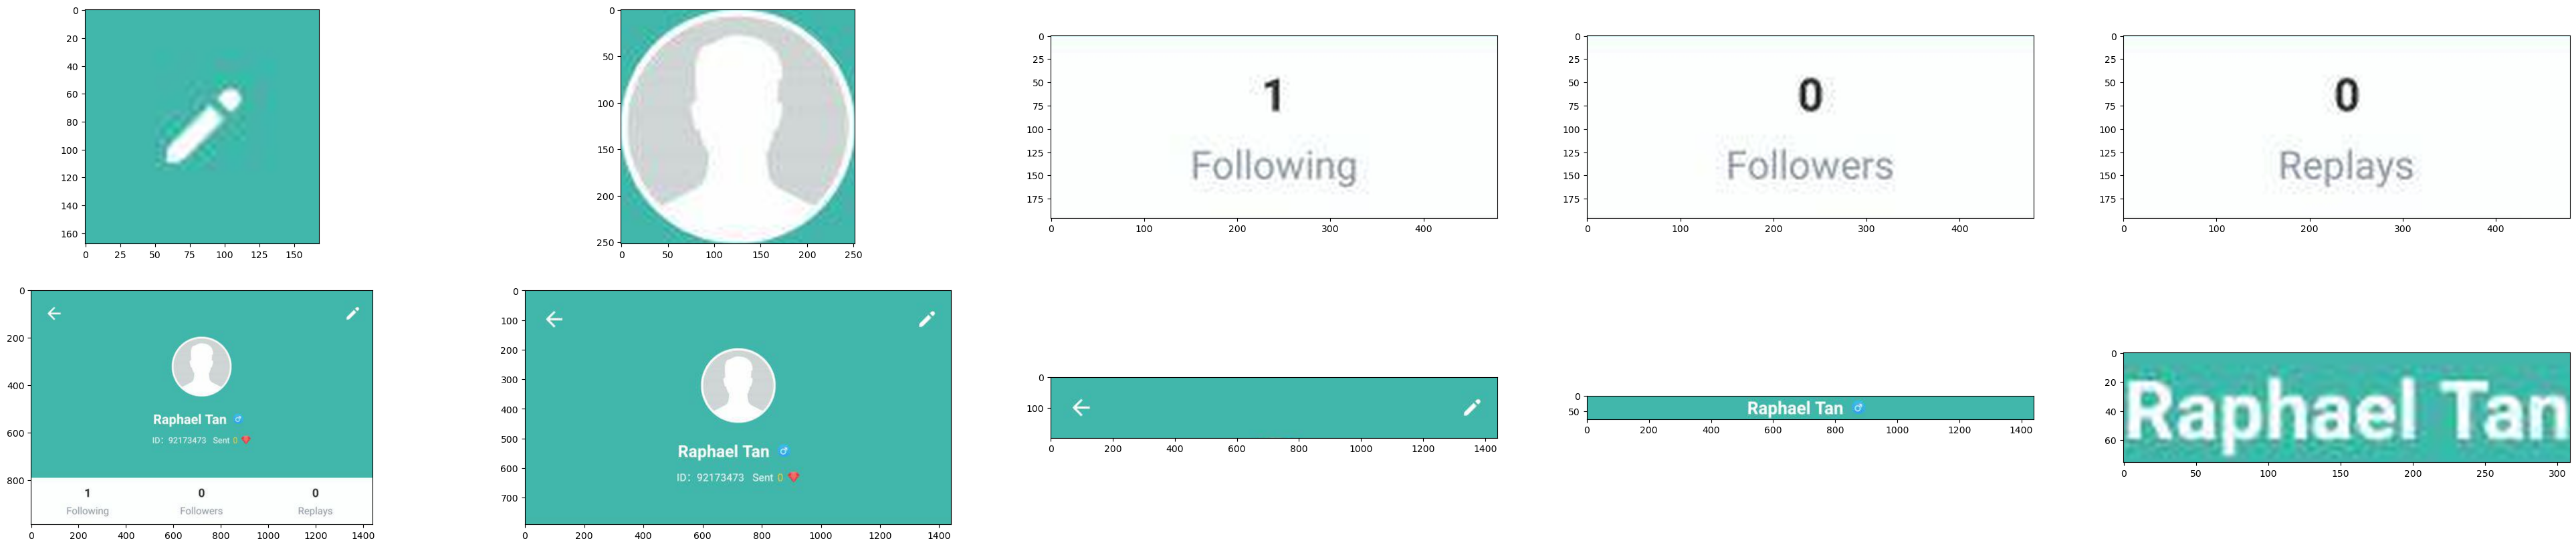

In [36]:
fig = plt.figure(figsize=(50,10))
a = 1
for i in segments:
    fig.add_subplot(2,5,a)
    plt.imshow(i)
    a+=1

plt.show()

In [37]:
appsthetics_predictor = torch.load("../Dataset_estetica/Regressao/model123")

In [48]:
mu, log_var = vae.encode(test_dataset[dataset_index][0].to(accelerator.device))
z = vae.reparameterize(mu, log_var)
gd = GradientDescent(vae, z, segments,appsthetics_predictor["model"], "cpu")

Mean shape: torch.Size([32])
Cov shape: torch.Size([32, 32])


In [49]:
mean = torch.tensor([0.0]*z.shape[1])
cov = torch.tensor([1.0]*z.shape[1])
covariance = torch.diag(cov)
loss_fn = MultivariateNormalLoss(mean, covariance, accelerator.device)

In [50]:
loss = loss_fn(z)

In [51]:
loss

tensor(18.4207, device='cuda:0', grad_fn=<MeanBackward0>)

In [52]:
x = gd.forward()

tensor([[[0.4188, 0.1152],
         [0.4112, 0.1090],
         [0.4113, 0.1092],
         [0.4113, 0.1093],
         [0.4138, 0.1115],
         [0.8867, 0.2298],
         [0.7363, 0.1906],
         [0.6459, 0.1747],
         [0.6100, 0.1704],
         [0.6120, 0.1698]]], grad_fn=<TanhBackward0>)
cpu
Max val: 1.0
generated_image.unsqueeze(0) device: cpu


In [53]:
x[0][0][0]+x[2]

tensor(19.1129, grad_fn=<AddBackward0>)

In [54]:
x[2]

tensor(18.4207, grad_fn=<MeanBackward0>)

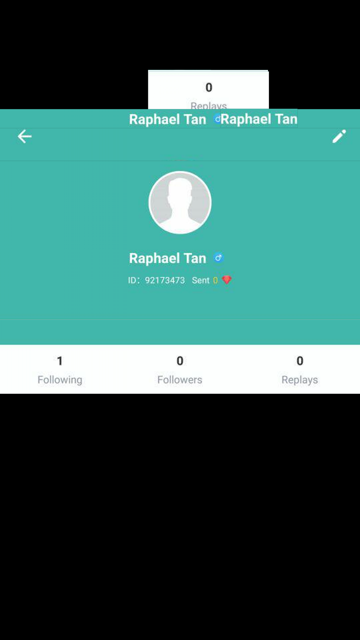

In [55]:
result_pil = transform_t_to_pil(x[1])
display(result_pil.resize((int(result_pil.size[0]*0.25),int(result_pil.size[1]*0.25))))

In [56]:
scores = []
optimiser_gd = torch.optim.AdamW(gd.parameters(),lr=0.005)
for x in range(25):
    score, image, mn_loss = gd.forward()
    score = score[0][0]
    loss = -score
    loss += mn_loss / 10.0
    print(f"aesthetics score: {score}, mn_loss: {mn_loss}, sum: {loss}")
    loss.backward()
    scores.append(loss.item())
    optimiser_gd.step()
    print(score)

tensor([[[0.4188, 0.1152],
         [0.4112, 0.1090],
         [0.4113, 0.1092],
         [0.4113, 0.1093],
         [0.4138, 0.1115],
         [0.8867, 0.2298],
         [0.7363, 0.1906],
         [0.6459, 0.1747],
         [0.6100, 0.1704],
         [0.6120, 0.1698]]], grad_fn=<TanhBackward0>)
cpu
Max val: 1.0
generated_image.unsqueeze(0) device: cpu
aesthetics score: 0.692200243473053, mn_loss: 18.42068099975586, sum: 1.1498677730560303
tensor(0.6922, grad_fn=<SelectBackward0>)
tensor([[[0.4289, 0.1389],
         [0.5179, 0.1787],
         [0.4022, 0.1223],
         [0.4029, 0.1228],
         [0.5570, 0.1966],
         [0.9980, 0.7011],
         [0.9887, 0.5751],
         [0.9769, 0.5133],
         [0.9761, 0.5209],
         [0.9687, 0.4836]]], grad_fn=<TanhBackward0>)
cpu
Max val: 1.0
generated_image.unsqueeze(0) device: cpu
aesthetics score: 2.4697513580322266, mn_loss: 18.42068099975586, sum: -0.6276832818984985
tensor(2.4698, grad_fn=<SelectBackward0>)
tensor([[[0.4254, 0.1203],

KeyboardInterrupt: 

In [57]:
score, img, pdf_loss = gd.forward()

tensor([[[0.4437, 0.1195],
         [0.4430, 0.1196],
         [0.4409, 0.1189],
         [0.6166, 0.1371],
         [0.4386, 0.1176],
         [0.9413, 0.0596],
         [0.6466, 0.1342],
         [0.4462, 0.1213],
         [0.8982, 0.0792],
         [0.7823, 0.1054]]], grad_fn=<TanhBackward0>)
cpu
Max val: 1.0
generated_image.unsqueeze(0) device: cpu


In [58]:
score, pdf_loss

(tensor([[581.3774]], grad_fn=<AddmmBackward0>),
 tensor(18.4207, grad_fn=<MeanBackward0>))

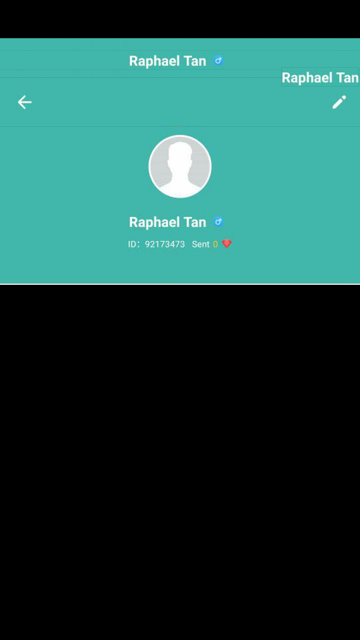

In [60]:
result_pil = transform_t_to_pil(img)
display(result_pil.resize((int(result_pil.size[0]*0.25),int(result_pil.size[1]*0.25))))

In [148]:
score.device

device(type='cpu')